<a href="https://colab.research.google.com/github/pandu1992/belajarpython.com/blob/master/Network_effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 34ms/step
Episode: 469, Total Profit: 918864.3633271698
1/1 [==============================] - 0s 31ms/step
Episode: 470, Total Profit: 743616.9255840098
1/1 [==============================] - 0s 24ms/step
Episode: 471, Total Profit: 901954.2079380108
1/1 [==============================] - 0s 68ms/step
Episode: 472, Total Profit: 904301.3854788304
1/1 [==============================] - 0s 28ms/step
Episode: 473, Total Profit: 957207.5125524013
1/1 [==============================] - 0s 24ms/step
Episode: 474, Total Profit: 915071.132194634
1/1 [==============================] - 0s 27ms/step
Episode: 475, Total Profit: 917527.9361096537
1/1 [==============================] - 0s 31ms/step
Episode: 476, Total Profit: 828779.0973218028
1/1 [==============================] - 0s 41ms/step
Episode: 477, Total Profit: 917425.3587811562
1/1 [==============================] - 0s 30ms/step
Episode: 478, To

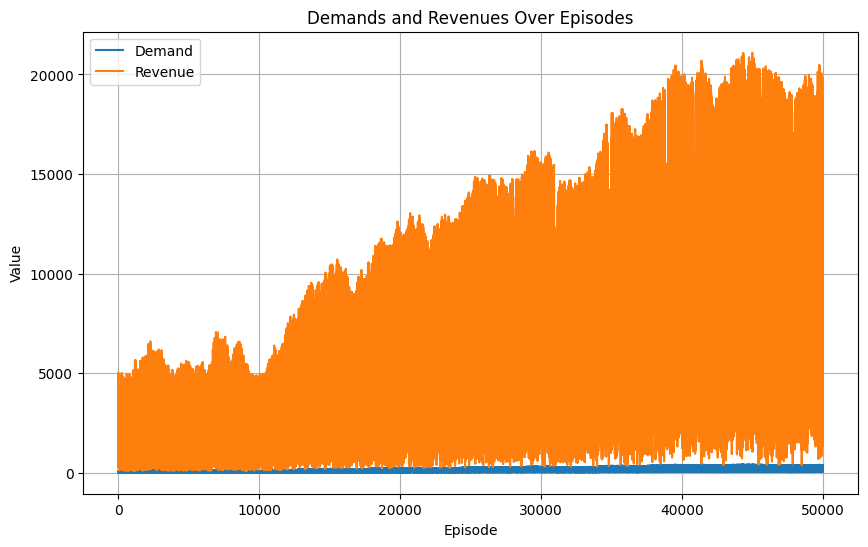

In [1]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the Deep Q-Network (DQN) class
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Define the environment simulation
class Environment:
    def __init__(self):
        self.state_size = 5  # Example state size (e.g., prices, demand, competitors, user base, etc.)
        self.action_size = 5  # Example action size (e.g., different price levels)
        self.dqn_agent = DQN(self.state_size, self.action_size)
        self.user_base = 1000  # Initial user base
        self.demands = []
        self.revenues = []

    def reset(self):
        # Initialize environment state
        self.user_base = max(1000, int(self.user_base * np.random.uniform(0.9, 1.1)))  # Simulate user base growth
        state = np.append(np.random.random(self.state_size - 1), self.user_base)
        return state.reshape(1, -1)  # Reshape state to (1, state_size) for compatibility with model

    def step(self, action):
        # Simulate environment dynamics based on action
        next_state = np.append(np.random.random(self.state_size - 1), self.user_base)  # Example: new state after taking action
        reward = self._calculate_reward(action, self.user_base)  # Calculate reward based on action and user base
        done = False  # Example: determine if episode is done
        return next_state.reshape(1, -1), reward, done

    def _calculate_reward(self, action, user_base):
        # Example profit-based reward function with privacy cost and network effects
        price_levels = [10, 20, 30, 40, 50]  # Example price levels
        price = price_levels[action]
        demand_multiplier = 1 + np.log(user_base / 1000)  # Demand multiplier based on user base (network effect)
        demand = np.random.randint(10, 100) * demand_multiplier  # Example demand simulation with network effect
        cost_per_unit = 5  # Example cost per unit
        revenue = price * demand
        cost = cost_per_unit * demand

        # Privacy cost based on the chosen price level
        privacy_cost = 0.1 * price  # Example: privacy cost as a percentage of price

        # Calculate profit considering privacy cost
        profit = revenue - cost - privacy_cost

        # Store demand and revenue for visualization
        self.demands.append(demand)
        self.revenues.append(revenue)

        return profit

# Main training loop and simulation
env = Environment()
state = env.reset()
num_episodes = 500

for episode in range(num_episodes):
    state = env.reset()
    total_profit = 0

    for time in range(100):
        action = env.dqn_agent.act(state)
        next_state, reward, done = env.step(action)
        env.dqn_agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_profit += reward

        if done:
            break

    env.dqn_agent.replay(batch_size=32)
    print(f"Episode: {episode + 1}, Total Profit: {total_profit}")

# Plotting demands and revenues
plt.figure(figsize=(10, 6))
plt.plot(env.demands, label='Demand')
plt.plot(env.revenues, label='Revenue')
plt.title('Demands and Revenues Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
